In [439]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path
import statsmodels.formula.api as smf 
import datetime
import time
import statsmodels.api as sm
from sklearn import utils, model_selection, linear_model, metrics, ensemble, tree, svm, preprocessing, neighbors
import xgboost as xgb
import pickle

In [440]:
import warnings
warnings.filterwarnings('ignore')

In [441]:
pd.set_option('display.max_columns', 30)  

In [443]:
sns.set(
    font_scale=1.2,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

### Предварительный анализ данных

In [447]:
df = pd.read_csv('LTV.csv')

In [448]:
df.rename(columns=lambda x: x.lower().replace(' ', '_'), inplace=True)    # переименуем колонки
df.drop(columns='customer', inplace=True)       # удалим колонку с идентификатором клиента

In [449]:
# преобразуем даты в количество оставшихся дней страховки (на самом деле количество дней до минимальной даты)
# чтобы работать с этим признаком как с количественным
df['effective_to_date'] = pd.to_datetime(df['effective_to_date'])  
td = df.effective_to_date - df.effective_to_date.min()       
df.effective_to_date = td.dt.days.values
df = df.rename(columns={"effective_to_date": "effective_days"})

In [450]:
df.head(2)

,state,customer_lifetime_value,response,coverage,education,effective_days,employmentstatus,gender,income,location_code,marital_status,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size
0,Washington,2763.519279,No,Basic,Bachelor,54,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,Arizona,6979.535903,No,Extended,Bachelor,30,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize


In [451]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          9134 non-null   object 
 1   customer_lifetime_value        9134 non-null   float64
 2   response                       9134 non-null   object 
 3   coverage                       9134 non-null   object 
 4   education                      9134 non-null   object 
 5   effective_days                 9134 non-null   int64  
 6   employmentstatus               9134 non-null   object 
 7   gender                         9134 non-null   object 
 8   income                         9134 non-null   int64  
 9   location_code                  9134 non-null   object 
 10  marital_status                 9134 non-null   object 
 11  monthly_premium_auto           9134 non-null   int64  
 12  months_since_last_claim        9134 non-null   i

In [452]:
df.describe(include='all', datetime_is_numeric=True)

,state,customer_lifetime_value,response,coverage,education,effective_days,employmentstatus,gender,income,location_code,marital_status,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size
count,9134,9134.000000,9134,9134,9134,9134.000000,9134,9134,9134.000000,9134,9134,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134,9134,9134,9134,9134.000000,9134,9134
unique,5,NaN,2,3,5,NaN,5,2,NaN,3,3,NaN,NaN,NaN,NaN,NaN,3,9,4,4,NaN,6,3
top,California,NaN,No,Basic,Bachelor,NaN,Employed,F,NaN,Suburban,Married,NaN,NaN,NaN,NaN,NaN,Personal Auto,Personal L3,Offer1,Agent,NaN,Four-Door Car,Medsize
freq,3150,NaN,7826,5568,2748,NaN,5698,4658,NaN,5779,5298,NaN,NaN,NaN,NaN,NaN,6788,3426,3752,3477,NaN,4621,6424
mean,NaN,8004.940475,NaN,NaN,NaN,28.837749,NaN,NaN,37657.380009,NaN,NaN,93.219291,15.097000,48.064594,0.384388,2.966170,NaN,NaN,NaN,NaN,434.088794,NaN,NaN
std,NaN,6870.967608,NaN,NaN,NaN,16.942769,NaN,NaN,30379.904734,NaN,NaN,34.407967,10.073257,27.905991,0.910384,2.390182,NaN,NaN,NaN,NaN,290.500092,NaN,NaN
min,NaN,1898.007675,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,61.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN,NaN,NaN,0.099007,NaN,NaN
25%,NaN,3994.251794,NaN,NaN,NaN,14.000000,NaN,NaN,0.000000,NaN,NaN,68.000000,6.000000,24.000000,0.000000,1.000000,NaN,NaN,NaN,NaN,272.258244,NaN,NaN
50%,NaN,5780.182197,NaN,NaN,NaN,28.000000,NaN,NaN,33889.500000,NaN,NaN,83.000000,14.000000,48.000000,0.000000,2.000000,NaN,NaN,NaN,NaN,383.945434,NaN,NaN
75%,NaN,8962.167041,NaN,NaN,NaN,43.000000,NaN,NaN,62320.000000,NaN,NaN,109.000000,23.000000,71.000000,0.000000,4.000000,NaN,NaN,NaN,NaN,547.514839,NaN,NaN


У нас есть 9 количественных признаков (включая зависимую переменную ltv) и 14 категориальных

При этом значения каждого из категориальных признаков распределены довольно равномерно и сбалансированно:

In [453]:
# распределение количества уникальных значений для каждого категориального признака
for col in df.select_dtypes(exclude='number').columns.values:     
    print(col, np.unique(df[col], return_counts=True)[0], np.unique(df[col], return_counts=True)[1])

state ['Arizona' 'California' 'Nevada' 'Oregon' 'Washington'] [1703 3150  882 2601  798]
response ['No' 'Yes'] [7826 1308]
coverage ['Basic' 'Extended' 'Premium'] [5568 2742  824]
education ['Bachelor' 'College' 'Doctor' 'High School or Below' 'Master'] [2748 2681  342 2622  741]
employmentstatus ['Disabled' 'Employed' 'Medical Leave' 'Retired' 'Unemployed'] [ 405 5698  432  282 2317]
gender ['F' 'M'] [4658 4476]
location_code ['Rural' 'Suburban' 'Urban'] [1773 5779 1582]
marital_status ['Divorced' 'Married' 'Single'] [1369 5298 2467]
policy_type ['Corporate Auto' 'Personal Auto' 'Special Auto'] [1968 6788  378]
policy ['Corporate L1' 'Corporate L2' 'Corporate L3' 'Personal L1' 'Personal L2'
 'Personal L3' 'Special L1' 'Special L2' 'Special L3'] [ 359  595 1014 1240 2122 3426   66  164  148]
renew_offer_type ['Offer1' 'Offer2' 'Offer3' 'Offer4'] [3752 2926 1432 1024]
sales_channel ['Agent' 'Branch' 'Call Center' 'Web'] [3477 2567 1765 1325]
vehicle_class ['Four-Door Car' 'Luxury Car' '

Некоторые признаки, как видится, дублируют друг друга. Например доход связан с данными о трудоустройстве. Что логично.

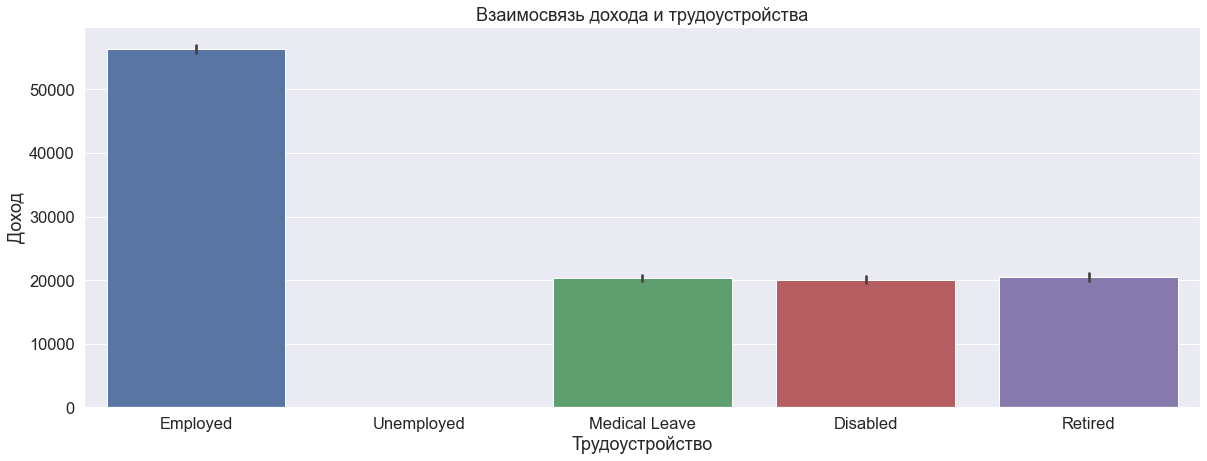

In [454]:
sns.set(font_scale=1.5)
ax = sns.barplot(df.employmentstatus, df.income)
ax.set_xlabel('Трудоустройство')  
ax.set_ylabel('Доход')
ax.set_title('Взаимосвязь дохода и трудоустройства');

А вот класс машины и размеры машины особенно не связаны, соотношение везде примерно одинаковое.

In [455]:
pd.crosstab(df.vehicle_class, df.vehicle_size)

vehicle_size,Large,Medsize,Small
vehicle_class,,,
Four-Door Car,475,3237,909
Luxury Car,16,106,41
Luxury SUV,18,125,41
SUV,167,1308,321
Sports Car,49,366,69
Two-Door Car,221,1282,383


Как бы то ни было, я пробовал удалять коррелирующие признаки из обучающих выборок, это ухудшало результаты. Поэтому работал со всеми исходными признаками (кроме идентификатора клиента)

Гистограмма распределения зависимой переменной LTV говорит о том, что у большинства клиентов (около 80%) этот показатель меньше 10 тысяч.

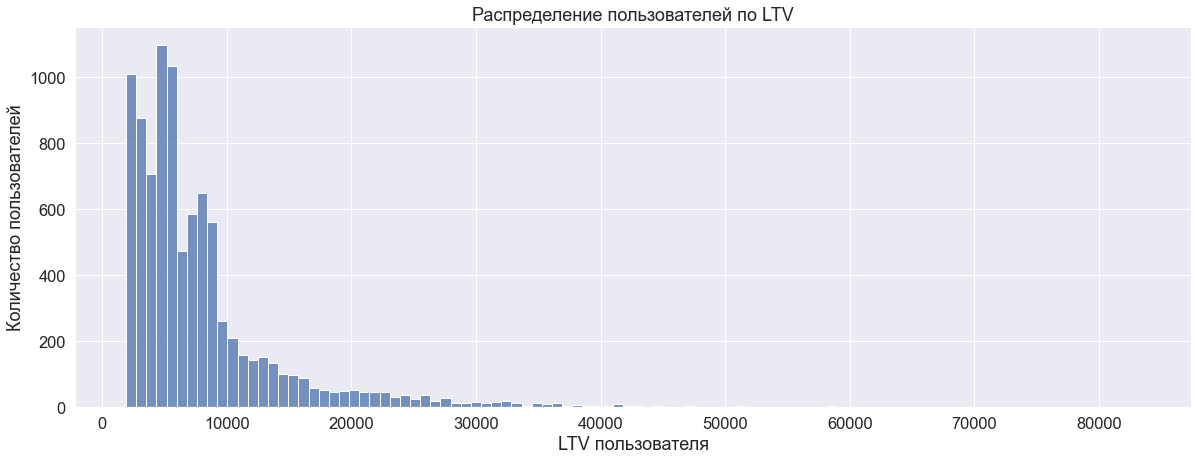

In [457]:
ax = sns.histplot(df.customer_lifetime_value, bins=100)
ax.set_xlabel('LTV пользователя')  
ax.set_ylabel('Количество пользователей')
ax.set_title('Распределение пользователей по LTV');

In [458]:
np.percentile(df.customer_lifetime_value, q=80)       # значение LTV для процентиля 80

10208.92761

Построим таблицу взаимосвязей для количественных признаков:

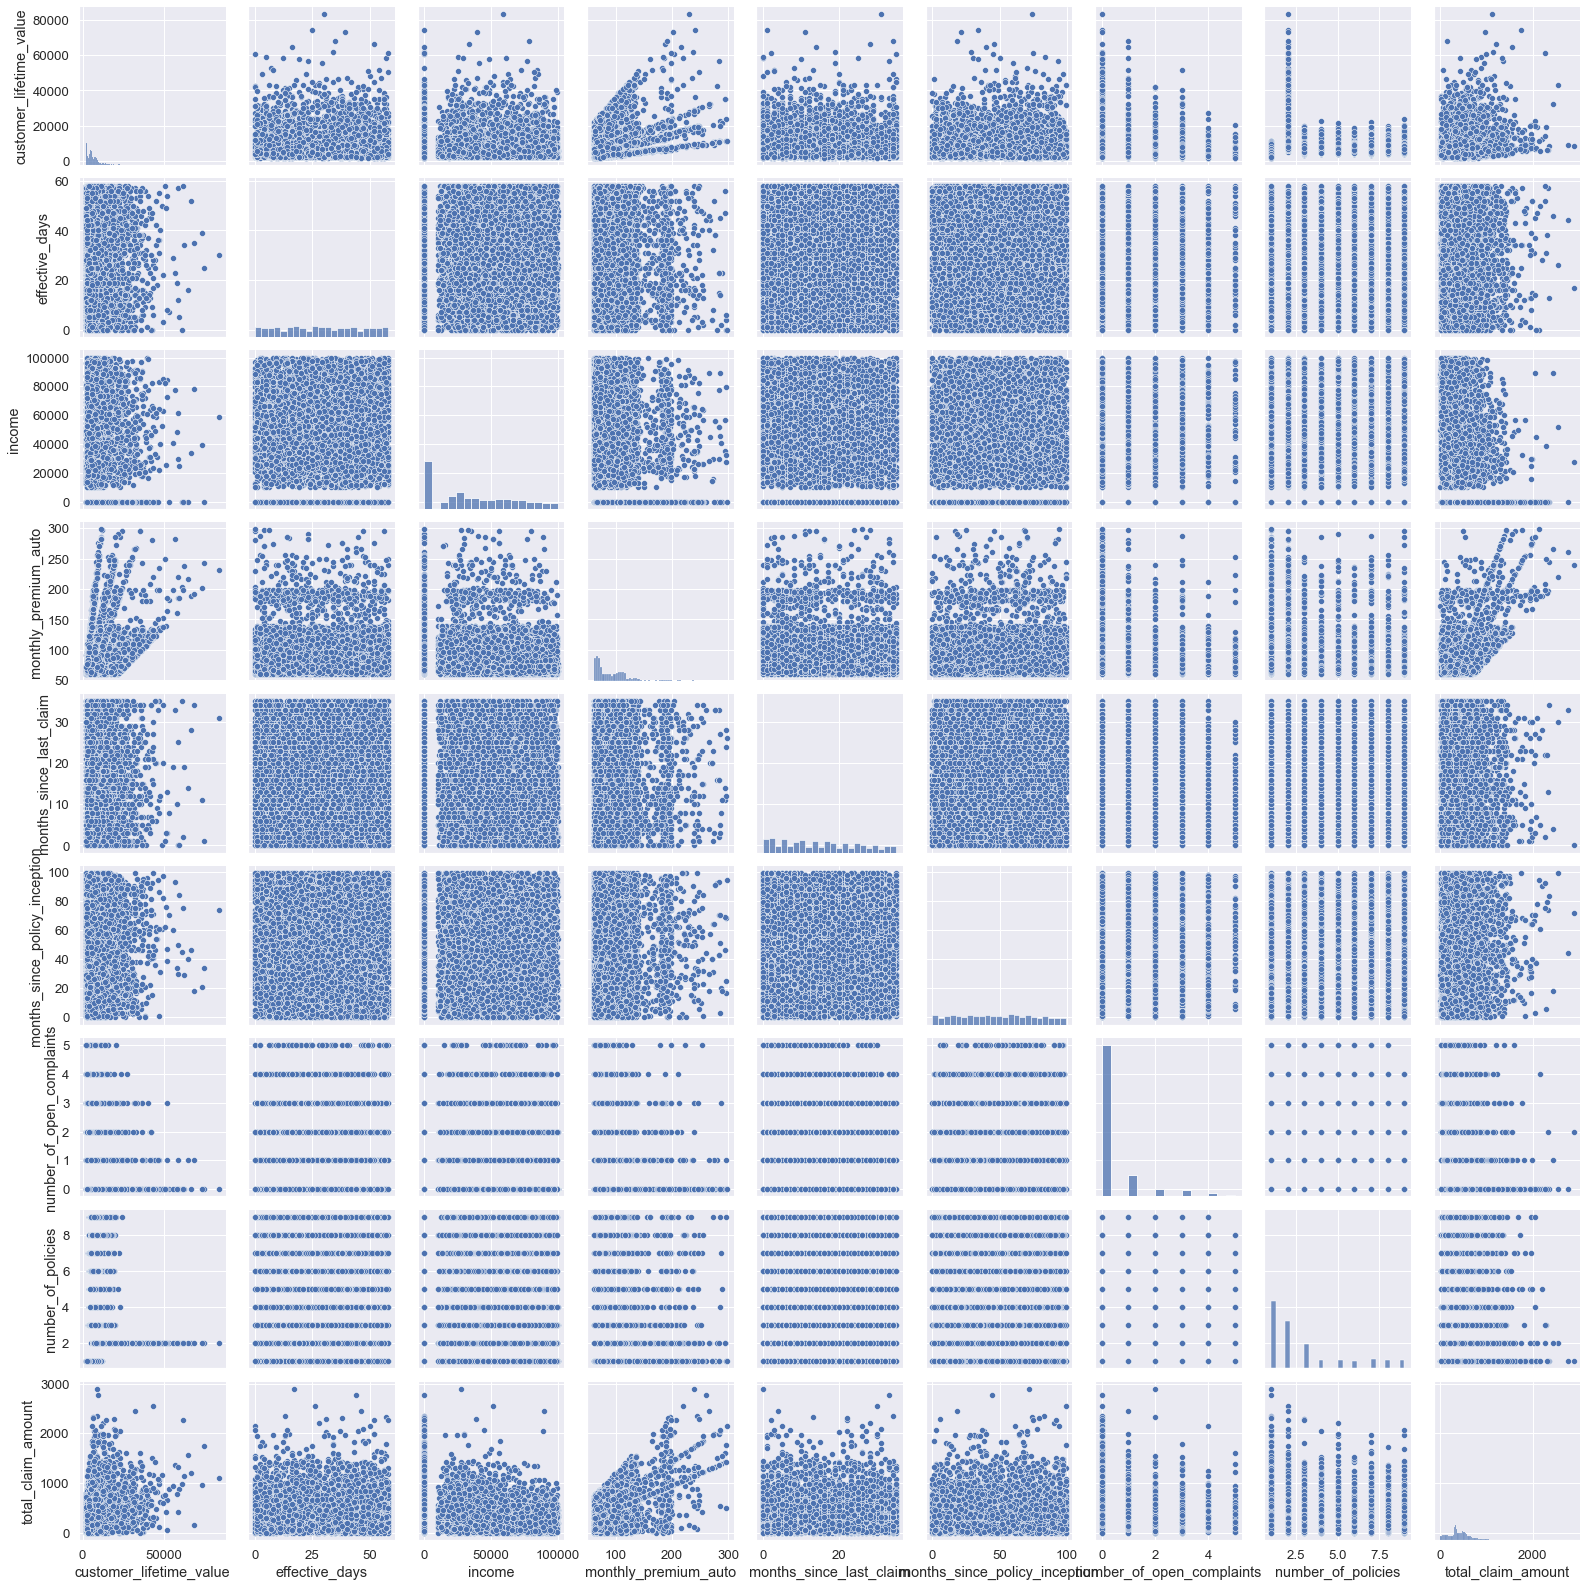

In [459]:
sns.set(font_scale=1.2)
sns.pairplot(df);

LTV взаимосвязан разве что только с признаком monthly_premium_auto. На обучении окажется, что это второй по значимости признак для модели.

При этом между собой признаки тоже в основном не коррелируют.

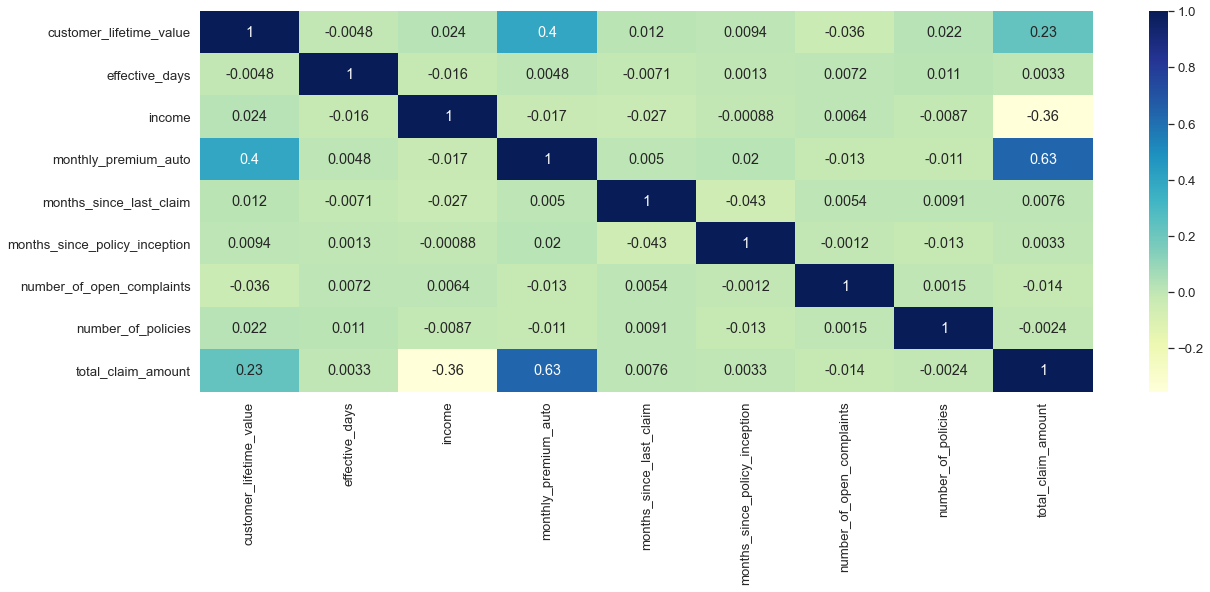

In [460]:
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu");

Для работы с категориальными признаками необходимо их закодировать по принципу one hot encoding

In [461]:
df_dummy = pd.get_dummies(data=df.select_dtypes(exclude='number'))

In [462]:
df_numeric = df.select_dtypes(include='number')

Объединим в новый датафрейм количественные и закодированные категориальные признаки:

In [463]:
df_fixed = pd.concat([df_numeric, df_dummy], axis=1)

In [464]:
df_fixed.shape

(9134, 66)

Попробуем построить базовую модель линейной регрессии (зависимая переменная - LTV):

In [465]:
X = df_fixed.loc[:, df_fixed.columns != 'customer_lifetime_value']
X = sm.add_constant(X)  
Y = df_fixed.customer_lifetime_value
model = sm.OLS(Y, X)  
results = model.fit()  
print(results.summary())  

                               OLS Regression Results                              
Dep. Variable:     customer_lifetime_value   R-squared:                       0.169
Model:                                 OLS   Adj. R-squared:                  0.165
Method:                      Least Squares   F-statistic:                     37.83
Date:                     Wed, 17 Mar 2021   Prob (F-statistic):          2.87e-322
Time:                             01:19:39   Log-Likelihood:                -92811.
No. Observations:                     9134   AIC:                         1.857e+05
Df Residuals:                         9084   BIC:                         1.861e+05
Df Model:                               49                                         
Covariance Type:                 nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

Линейная регрессия не очень хорошо справилась. Коэффициент детерминации R**2 составляет всего 0,165, что мало для эффективных предсказаний

### Подбор моделей для задачи предсказания

In [466]:
# перемешаем рабочий датафрейм
df_fixed = utils.shuffle(df_fixed, random_state=5)  # зафиксировал random_state для повторяемости результатов

In [467]:
# Разделим выборку на тренировочную и контрольную в отношении 80 на 20
X = df_fixed.loc[:, df_fixed.columns != 'customer_lifetime_value']
y = df_fixed.customer_lifetime_value
X, X_control, y, y_control = model_selection.train_test_split(X, y, test_size=0.2, random_state=5)

In [469]:
# На кросс-валидации будем делить выборку на 10 частей, поскольку данных для обучения не очень много
kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=5)

Для оценки качества модели будем использовать метрику R**2

##### Линейная регрессия

In [470]:
estimator1 = linear_model.LinearRegression()

In [471]:
scores1 = model_selection.cross_val_score(estimator1, X, y, cv=kfold, scoring='r2')
scores1.mean()

0.15976273642066294

Модель на основе линейной регрессии из модуля sklearn справилась даже хуже, чем из модуля statsmodels. Наверное, потому что там использовался полный набор данных, а тут только 80%. Или просто из-за сортировки, из-за рандома.

##### Линейная регрессия с регуляризацией (ElasticNet)

Для отсечения ненужных признаков ElasticNet использует комбинацию l1 и l2 регуляризации. 

In [530]:
estimator3 = linear_model.ElasticNet()

In [531]:
%%time
scores3 = model_selection.cross_val_score(estimator3, X, y, cv=kfold, scoring='r2')
scores3.mean()

Wall time: 199 ms


0.16259602224419853

In [554]:
# на контрольных данных
estimator3.fit(X, y)
metrics.r2_score(y_control, estimator3.predict(X_control))

0.13442908892587502

Базовые настройки справились плохо. Попробуем подобрать параметры по сетке.

In [544]:
param_grid3 = {'alpha': np.arange(0, 4, 0.2), 'l1_ratio': np.arange(0, 1.1, 0.05)}

In [545]:
optimizer3 = model_selection.GridSearchCV(estimator3, param_grid3, scoring='r2', cv=kfold)

In [546]:
%%time
optimizer3.fit(X, y)

Wall time: 3min 29s


GridSearchCV(cv=KFold(n_splits=10, random_state=5, shuffle=True),
             estimator=ElasticNet(),
             param_grid={'alpha': array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
       2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8]),
                         'l1_ratio': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05])},
             scoring='r2')

In [547]:
optimizer3.best_estimator_

ElasticNet(alpha=0.2, l1_ratio=0.35000000000000003)

Проверим на контрольной выборке

In [548]:
metrics.r2_score(y_control, optimizer3.predict(X_control))

0.14098474976537412

Качество предсказаний чуть улучшилось, но все равно низкое.

##### Дерево решений

In [480]:
estimator4 = tree.DecisionTreeRegressor()

In [481]:
%%time
scores4 = model_selection.cross_val_score(estimator4, X, y, scoring='r2', cv=kfold)
scores4.mean()

Wall time: 917 ms


0.43832194149337844

In [482]:
# estimator4.fit(X, y)
# metrics.r2_score(y_control, estimator4.predict(X_control))

Метрика увеличилась до 0,44. Попробуем подобрать параметры:

In [483]:
param_grid4 = {'max_depth': np.arange(1, 10, 1),
               'min_samples_split': np.arange(1, 4, 1),
               'min_samples_leaf': np.arange(1, 4, 1)     
              }

In [484]:
optimizer4 = model_selection.GridSearchCV(estimator4, param_grid4, scoring='r2', cv=kfold)

In [485]:
%%time
optimizer4.fit(X, y)

Wall time: 18.7 s


GridSearchCV(cv=KFold(n_splits=10, random_state=5, shuffle=True),
             estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'min_samples_leaf': array([1, 2, 3]),
                         'min_samples_split': array([1, 2, 3])},
             scoring='r2')

In [486]:
optimizer4.best_params_

{'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2}

In [487]:
metrics.r2_score(y_control, optimizer4.predict(X_control))

0.6623859616465496

Метрика снова увеличилась до 0.66

##### Случайный лес

Ансамбль из решающих деревьев

In [488]:
estimator5 = ensemble.RandomForestRegressor()

In [489]:
%%time
scores5 = model_selection.cross_val_score(estimator5, X, y, scoring='r2', cv=kfold, n_jobs=-1)
scores5.mean()

Wall time: 14.8 s


0.7011284761428415

Базовая конфигурация уже лучше, чем лучшая из варианта с DecisionTree

In [549]:
# на контрольной выборке
estimator5.fit(X, y)
metrics.r2_score(y_control, estimator5.predict(X_control))

0.7065148082135941

In [491]:
param_grid5 = {'n_estimators': np.arange(10, 200, 10),
                'max_depth': [None], #, 2, 4, 5, 10, 20]
                'min_samples_split': np.arange(1, 4, 1),
               'min_samples_leaf': np.arange(1, 4, 1)                              
              }

In [492]:
optimizer5 = model_selection.GridSearchCV(estimator5, param_grid5, cv=kfold, scoring='r2', n_jobs=-1)

In [493]:
%%time
optimizer5.fit(X, y)

Wall time: 15min 25s


GridSearchCV(cv=KFold(n_splits=10, random_state=5, shuffle=True),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [None],
                         'min_samples_leaf': array([1, 2, 3]),
                         'min_samples_split': array([1, 2, 3]),
                         'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190])},
             scoring='r2')

In [494]:
optimizer5.best_estimator_

RandomForestRegressor(min_samples_leaf=3, n_estimators=150)

In [495]:
metrics.r2_score(y_control, optimizer5.predict(X_control))

0.7093211412417539

Значение метрики еще немного увеличилось.

##### Градиентный бустинг

Проверим сначала базовый инструмент из библиотеки sklearn

In [496]:
estimator6 = ensemble.GradientBoostingRegressor()

In [497]:
%%time
scores6 = model_selection.cross_val_score(estimator6, X, y, scoring='r2', cv=kfold, n_jobs=-1)
scores6.mean()

Wall time: 2.46 s


0.6800429216875181

In [498]:
# estimator6.fit(X, y)
# metrics.r2_score(y_control, estimator6.predict(X_control))

In [499]:
param_grid6 = {'n_estimators': np.arange(10, 140, 10),
                'max_depth': np.arange(2, 8, 1), 
#                'learning_rate': [0.1, 0.2, 0.5]
               'min_samples_split': np.arange(1, 4, 1),
              'min_samples_leaf': np.arange(1, 4, 1)
              }

In [500]:
optimizer6 = model_selection.GridSearchCV(estimator6, param_grid6, cv=kfold, scoring='r2', n_jobs=-1)

In [501]:
%%time
optimizer6.fit(X, y)

Wall time: 19min 15s


GridSearchCV(cv=KFold(n_splits=10, random_state=5, shuffle=True),
             estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'max_depth': array([2, 3, 4, 5, 6, 7]),
                         'min_samples_leaf': array([1, 2, 3]),
                         'min_samples_split': array([1, 2, 3]),
                         'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130])},
             scoring='r2')

In [502]:
optimizer6.best_estimator_

GradientBoostingRegressor(max_depth=7, min_samples_leaf=3, n_estimators=30)

In [503]:
metrics.r2_score(y_control, optimizer6.predict(X_control))

0.6853984951740335

Результат оказался хуже, чем для RandomForest.

##### XGBoost

А теперь тот же градиентный бустинг, только из специализированной библиотеки

In [504]:
estimator7 = xgb.XGBRegressor() 

In [505]:
%%time
scores7 = model_selection.cross_val_score(estimator7, X, y, scoring='r2', cv=kfold, n_jobs=-1)
scores7.mean()

Wall time: 4.55 s


0.6685099030699252

In [506]:
# estimator7.fit(X, y)
# metrics.r2_score(y_control, estimator7.predict(X_control))

In [507]:
param_grid7 = {'n_estimators': np.arange(20, 180, 10),
                'max_depth': np.arange(2, 8, 1), 
               'min_child_weight': np.arange(2, 8, 1),
               'learning_rate': [0.04, 0.05, 0.06, 0.07, 0.08]
              }


In [508]:
optimizer7 = model_selection.GridSearchCV(estimator7, param_grid7, cv=kfold, scoring='r2', n_jobs=-1)

In [509]:
%%time
optimizer7.fit(X, y)

Wall time: 1h 44min 5s


GridSearchCV(cv=KFold(n_splits=10, random_state=5, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monot...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_jobs=-1,
             param_grid={'l

In [510]:
optimizer7.best_params_

{'learning_rate': 0.07,
 'max_depth': 7,
 'min_child_weight': 6,
 'n_estimators': 60}

In [511]:
optimizer7.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.07, max_delta_step=0, max_depth=7,
             min_child_weight=6, missing=nan, monotone_constraints='()',
             n_estimators=60, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [512]:
metrics.r2_score(y_control, optimizer7.predict(X_control))

0.6855754032036558

На контрольной выборке результат почти такой же, как у стандартного градиентного бустинга. Хуже, чем у случайного леса.

### Анализ моделей

Таким образом лучшие результаты на отложенной выборке - метрика R**2 = 0.709 - показала модель на основе случайного леса (RandomForestRegressor(min_samples_leaf=3, n_estimators=150) )

Покажем на графике, как отклоняются предсказания различных моделей от контрольной выборки.

Чтобы уменьшить шум и повысить информативность, применим для графиков скользящее среднее с окном 200

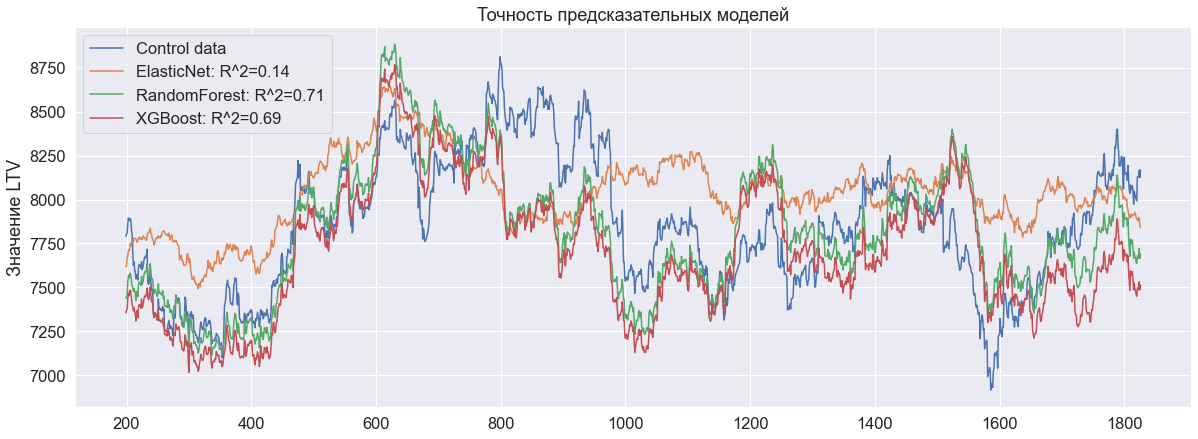

In [556]:
sns.set(font_scale=1.5)
window = 200
control_window = y_control.reset_index(drop=True).rolling(window).mean()
for estimator, label in zip([control_window, optimizer3, optimizer5, optimizer7], 
                            ['Control data', 'ElasticNet', 'RandomForest', 'XGBoost']):
    if estimator is control_window:        
        ax = sns.lineplot(data=control_window, x=control_window.index, y=control_window, label=f'{label}')
    else:
        pred_window = pd.Series(estimator.predict(X_control)).rolling(window).mean()
        r2 = round(metrics.r2_score(y_control, estimator.predict(X_control)), 2)
        ax = sns.lineplot(data=pred_window, x=pred_window.index, y=pred_window, label=f'{label}: R^2={r2}')
ax.set_ylabel('Значение LTV')
ax.set_title('Точность предсказательных моделей');    

ElasticNet очень плохо предсказывает данные, тогда как случайный лес и градиентный бустинг близки к контрольной выборке. Хотя и местами значительно расходятся.

### Анализ признаков

Для модели случайного леса существует метод, который определяет важность признаков

In [514]:
def plotting_feature_priority(X, model, n=3):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_names = X.columns
    d_first = X.shape[1]
    plt.figure(figsize=(20, 8))
    plt.title("Значимость признаков", fontsize=20)
    plt.bar(range(d_first), importances[indices[:d_first]], align='center')
    plt.xticks(range(d_first), np.array(feature_names)[indices[:d_first]], rotation=90)
    plt.xlim([-1, d_first])
#     best_features = indices[:n]
#     best_features_names = feature_names[best_features]
#     print(f'Первые {n} значимых признаков {list(best_features_names)} из {d_first} ')
    plt.show()

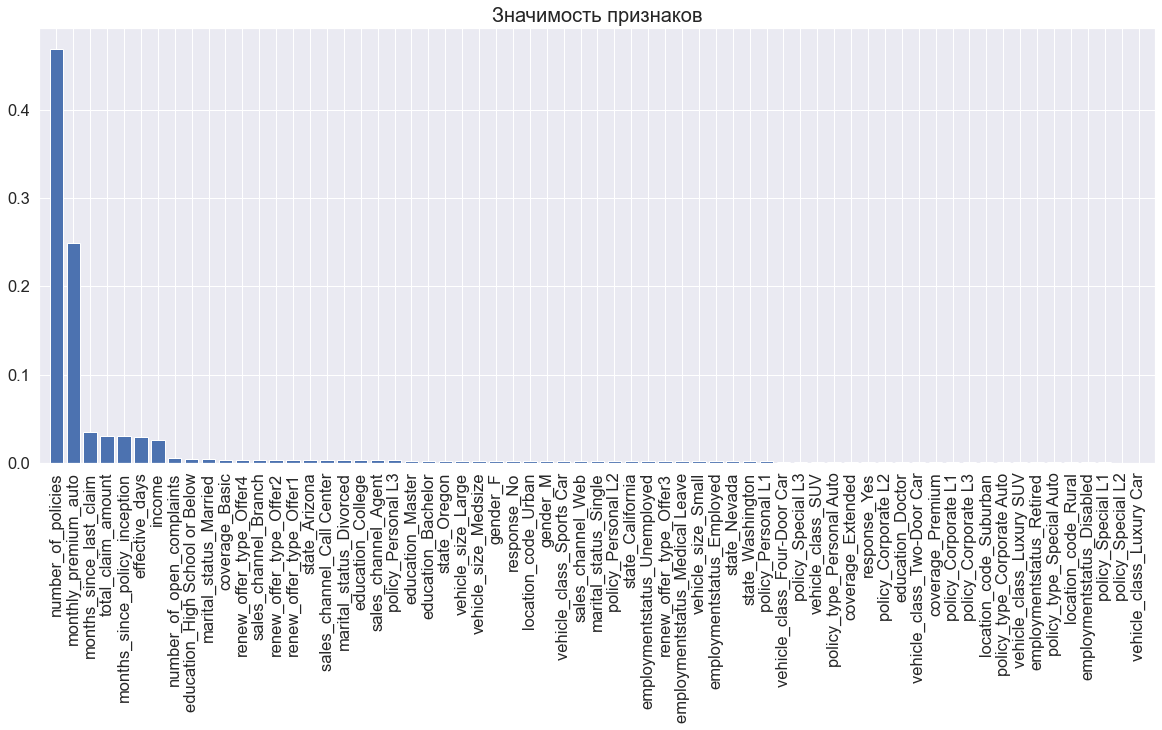

In [555]:
plotting_feature_priority(X, estimator5)

Наиболее значимые признаки: number_of_policies, monthly_premium_auto, months_since_last_claim.

Я так и не понял, что такое monthly_premium_auto, в описании задачи не было пояснения. Поэтому не знаю, как это интерпретировать. Но оно коррелирует с LTV, и чем оно больше, тем больше LTV.

Зато number_of_policies легко интерпретировать. Чем больше клиент покупает полисов, тем больше денег он приносит. 

Аналогично с months_since_last_claim. Чем больше времени прошло с последнего обращения клиента за выплатой - тем больше его ценность. 

Похожая, но обратная ситуация с признаками months_since_policy_inception и total_claim_amount. Чем их значения меньше - тем больше ценность клиента. Еще оказывают влияние срок действия полиса и доход клиента.


Другими словами, ценнее клиенты, которые покупают много полисов и не обращаются за выплатами, или эти выплаты небольшие. Какое откровение :)


А вот такие признаки как пол, тип страховки, регион и место проживания почти не оказывают влияния на модель. Я пробовал их удалять, и тогда результат немного меняется, даже иногда чуть улучшается в третьем знаке. Но если их удалять то, думаю, только для целей быстродействия. Качество модели принципиально не изменится.